In [1]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle
import json
tqdm.pandas()

In [2]:
df = pd.read_pickle("Pickles/lemmatized.pkl")

### Machine Learning Models

1. Preprocess dataframe
2. Load Word Embeddings
3. Train Models
4. Model Evaluation
5. Continue Training for More Epochs


In [3]:
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, GRU,CuDNNGRU,Input, LSTM, Embedding, Bidirectional
from keras.layers import Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, TimeDistributed, BatchNormalization
from keras.layers import concatenate as lconcat
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K


#sess_config.gpu_options.allow_growth = True
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
from sklearn.metrics import roc_auc_score
from keras.utils import np_utils,plot_model, multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3888345772746440188
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11273460122
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 15903324187681983473
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 11287530701
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 6246870232400548417
physical_device_desc: "device: 1, name: Tesla K80, pci bus id: 0000:00:05.0, compute capability: 3.7"
]


In [4]:
#### Define number of words, and embedding dimensions
max_words = 34603
embed_dim = 100

def load_embeddings(vec_file):
    print("Loading Glove Model")
    f = open(vec_file,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done. {} words loaded!".format(len(model)))
    return model

def tokenize_and_pad(docs,max_words=max_words):
    global t
    t = Tokenizer()
    t.fit_on_texts(docs)
    docs = pad_sequences(sequences = t.texts_to_sequences(docs),maxlen = max_words, padding = 'post')
    global vocab_size
    vocab_size = len(t.word_index) + 1
    
    return docs

def oversample(X,docs,y):
    # Get number of rows with imbalanced class
    target = y.sum().idxmax()
    n = y[target].sum()
    # identify imbalanced targets
    imbalanced = y.drop(target,axis=1)
    #For each target, create a dataframe of randomly sampled rows, append to list
    append_list =  [y.loc[y[col]==1].sample(n=n-y[col].sum(),replace=True,random_state=20) for col in imbalanced.columns]
    append_list.append(y)
    y = pd.concat(append_list,axis=0)
    # match y indexes on other inputs
    X = X.loc[y.index]
    docs = pd.DataFrame(docs_train,index=y_train.index).loc[y.index]
    assert (y.index.all() == X.index.all() == docs.index.all())
    return X,docs.values,y

In [5]:
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('items')),columns=mlb.classes_,),sort=False,how="left")

In [6]:
# Separate into X and Y
cols = ['GICS Sector','vix','rm_week','rm_month', 'rm_qtr', 'rm_year']
cols.extend(list(mlb.classes_))
X = df[cols]
docs = df['processed_text']

y = df['signal']

# Get Dummies

docs = tokenize_and_pad(docs)
X = pd.get_dummies(columns = ['GICS Sector'],prefix="sector",data=X)
y = pd.get_dummies(columns=['signal'],data=y)

aux_shape = len(X.columns)

In [7]:
# Split into train and test data
X_train, X_test, y_train, y_test, docs_train, docs_test = train_test_split(X, y,docs,
                                                    stratify=y, 
                                                    test_size=0.3,
                                                    random_state = 20)

In [8]:
cont_features = ['vix','rm_week','rm_month', 'rm_qtr', 'rm_year']
aux_features = cont_features + [item for item in mlb.classes_]
x_scaler = StandardScaler()
X_train[cont_features] = x_scaler.fit_transform(X_train[cont_features])
X_test[cont_features] = x_scaler.transform(X_test[cont_features])

X_train, docs_train, y_train = oversample(X_train, docs_train, y_train)

/home/Yusuf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/Yusuf/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/Yusuf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [9]:
embeddings_index = load_embeddings("glove.6B.100d.txt")

Loading Glove Model
Done. 400000 words loaded!


In [10]:
words_not_found = []

embedding_matrix = np.zeros((vocab_size, embed_dim))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 6391114


In [3]:
from sklearn.metrics import roc_auc_score

# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true,y_pred)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

## 3. Build & Train Models

In [9]:
def build_model(output_classes,architecture,aux_shape=aux_shape,vocab_size=vocab_size,embed_dim=embed_dim,embedding_matrix=embedding_matrix,max_seq_len=max_words):
    
    with tf.device('/cpu:0'):
        main_input= Input(shape=(max_seq_len,),name='doc_input')
        main = Embedding(input_dim = vocab_size,
                            output_dim = embed_dim,
                            weights=[embedding_matrix], 
                            input_length=max_seq_len, 
                            trainable=False)(main_input)

    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        main = Dense(32, activation='relu')(main)
        main = Dropout(0.2)(main)
        main = Flatten()(main)
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network
        main = Conv1D(64, 3, strides=1, padding='same', activation='relu')(main)
        #Cuts the size of the output in half, maxing over every 2 inputs
        main = MaxPooling1D(pool_size=3)(main)
        main = Dropout(0.2)(main)
        main = Conv1D(32, 3, strides=1, padding='same', activation='relu')(main)
        main = GlobalMaxPooling1D()(main)
        #model.add(Dense(output_classes, activation='softmax'))
    elif architecture == 'rnn':
        # LSTM network
        main = Bidirectional(CuDNNGRU(64, return_sequences=False),merge_mode='concat')(main)
        main = BatchNormalization()(main)
    elif architecture =="rnn_cnn":
        main = Conv1D(64, 5, padding='same', activation='relu')(main)
        main = MaxPooling1D()(main)
        main = Dropout(0.2)(main)
        main = Bidirectional(CuDNNGRU(32,return_sequences=False),merge_mode='concat')(main)
        main = BatchNormalization()(main)
   
    else:
        print('Error: Model type not found.')
        
    auxiliary_input = Input(shape=(aux_shape,), name='aux_input')
    x = lconcat([main, auxiliary_input])
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    main_output = Dense(output_classes, activation='sigmoid', name='main_output')(x)
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output],name=architecture)
        
    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model = multi_gpu_model(model)
    model.compile('adam', 'categorical_crossentropy',metrics=['accuracy',auc_roc])
    
    return model

def plot_metrics(model_dict,metric,x_label,y_label):
    plots = 1
    plt.figure(figsize=[15,10])
    for model, history in model_dict.items():
        plt.subplot(2,2,plots)
        plt.plot(history[metric])
        #plt.plot(history.history['val_acc'])
        plt.title('{0} {1}'.format(model,metric))
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plots += 1
    #plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    plt.savefig("Graphs/{}.png".format(metric),format="png")
    plt.show()
    
def gen():
    print('generator initiated')
    idx = 0
    while True:
        yield [docs_train[:32], X_train[:32]], y_train[:32]
        print('generator yielded a batch %d' % idx)
        idx += 1

NameError: name 'aux_shape' is not defined

In [11]:
# Save data
np.save("Pickles/docs_train.npy",docs_train)
np.save("Pickles/docs_test.npy",docs_test)

X_train.to_pickle("Pickles/X_train.pkl")
X_test.to_pickle("Pickles/X_test.pkl")

y_train.to_pickle("Pickles/y_train.pkl")
y_test.to_pickle("Pickles/y_test.pkl") 

np.save("Pickles/embedding_matrix.npy",embedding_matrix)

In [19]:
model_dict = dict()

In [ ]:
mlp = build_model(3,"mlp")

model_dict["mlp"] = mlp.fit([docs_train,X_train],y_train,batch_size=64,epochs=10,verbose=1) 

mlp.save("Data/models/mlp.hdf5")
with open('Data/trainHistory/mlp.pkl', 'wb') as file_pi:
    pickle.dump(model_dict["mlp"], file_pi)

In [21]:
rnn = build_model(3,"rnn")

model_dict["rnn"] = rnn.fit([docs_train,X_train],y_train,batch_size=32,epochs=10,verbose=1)

rnn.save("Data/models/rnn.hdf5")
with open('Data/trainHistory/rnn.pkl', 'wb') as file_pi:
    pickle.dump(model_dict["rnn"].history, file_pi)

Epoch 1/10
20457/20457 [==============================] - 3727s 182ms/step - loss: 1.0906 - acc: 0.3794 - auc_roc: 0.5223
Epoch 2/10
20457/20457 [==============================] - 3741s 183ms/step - loss: 1.0255 - acc: 0.4636 - auc_roc: 0.5731
Epoch 3/10
20457/20457 [==============================] - 3714s 182ms/step - loss: 0.9426 - acc: 0.5275 - auc_roc: 0.6256
Epoch 4/10
20457/20457 [==============================] - 3720s 182ms/step - loss: 0.9001 - acc: 0.5583 - auc_roc: 0.6619
Epoch 5/10
20457/20457 [==============================] - 3713s 181ms/step - loss: 0.8698 - acc: 0.5799 - auc_roc: 0.6870
Epoch 6/10
20457/20457 [==============================] - 3707s 181ms/step - loss: 0.8381 - acc: 0.6027 - auc_roc: 0.7060
Epoch 7/10
20457/20457 [==============================] - 3705s 181ms/step - loss: 0.8072 - acc: 0.6265 - auc_roc: 0.7218
Epoch 8/10
20457/20457 [==============================] - 3707s 181ms/step - loss: 0.7777 - acc: 0.6445 - auc_roc: 0.7354
Epoch 9/10
20457/20457 [

In [ ]:
cnn = build_model(3,"cnn")

model_dict["cnn"] = cnn.fit([docs_train,X_train],y_train,batch_size=64,epochs=10,verbose=1)

cnn.save("Data/models/cnn.hdf5")
with open('Data/trainHistory/cnn.pkl', 'wb') as file_pi:
    pickle.dump(model_dict["cnn"].history, file_pi)

In [22]:
rnn_cnn = build_model(3,"rnn_cnn")

model_dict["rnn_cnn"] = rnn_cnn.fit([docs_train,X_train],y_train,batch_size=32,epochs=10,verbose=1)

rnn_cnn.save("Data/models/rnn_cnn.hdf5")
with open('Data/trainHistory/rnn_cnn.pkl', 'wb') as file_pi:
    pickle.dump(model_dict["rnn_cnn"].history, file_pi)

Epoch 1/10
20457/20457 [==============================] - 1743s 85ms/step - loss: 1.0774 - acc: 0.3837 - auc_roc: 0.5230
Epoch 2/10
20457/20457 [==============================] - 1745s 85ms/step - loss: 0.9801 - acc: 0.4933 - auc_roc: 0.6111
Epoch 3/10
20457/20457 [==============================] - 1747s 85ms/step - loss: 0.9208 - acc: 0.5341 - auc_roc: 0.6612
Epoch 4/10
20457/20457 [==============================] - 1747s 85ms/step - loss: 0.8800 - acc: 0.5669 - auc_roc: 0.6901
Epoch 5/10
20457/20457 [==============================] - 1745s 85ms/step - loss: 0.8368 - acc: 0.6042 - auc_roc: 0.7114
Epoch 6/10
20457/20457 [==============================] - 1750s 86ms/step - loss: 0.7917 - acc: 0.6345 - auc_roc: 0.7302
Epoch 7/10
20457/20457 [==============================] - 1753s 86ms/step - loss: 0.7507 - acc: 0.6623 - auc_roc: 0.7465
Epoch 8/10
20457/20457 [==============================] - 1752s 86ms/step - loss: 0.7111 - acc: 0.6897 - auc_roc: 0.7611
Epoch 9/10
20457/20457 [========

## 4. Model Evaluation
#### Loss, Accuracy, and AUC_ROC graphs for training data

In [6]:
X_test = pd.read_pickle("Pickles/X_test.pkl")
y_test = pd.read_pickle("Pickles/y_test.pkl")
docs_test = np.load("Pickles/docs_test.npy")

mlp_hist = pickle.load(open("Data/trainHistory/mlp.pkl","rb"))
cnn_hist = pickle.load(open("Data/trainHistory/cnn.pkl","rb"))
rnn_hist = pickle.load(open("Data/trainHistory/rnn.pkl","rb"))
rnn_cnn_hist = pickle.load(open("Data/trainHistory/rnn_cnn.pkl","rb"))

In [12]:
def plot_metrics(model_dict,metric,x_label,y_label):
    plots = 1
    plt.figure(figsize=[15,10])
    for model, history in model_dict.items():
        plt.subplot(2,2,plots)
        plt.plot(history[metric])
        #plt.plot(history.history['val_acc'])
        plt.title('{0} {1}'.format(model,metric))
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plots += 1
    #plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    plt.savefig("Graphs/{}.png".format(metric),format="png")
    plt.show()
plt.style.use("ggplot")
model_dict = {"mlp": mlp_hist,
              "cnn": cnn_hist,
              "rnn": rnn_hist,
              "rnn_cnn": rnn_cnn_hist}

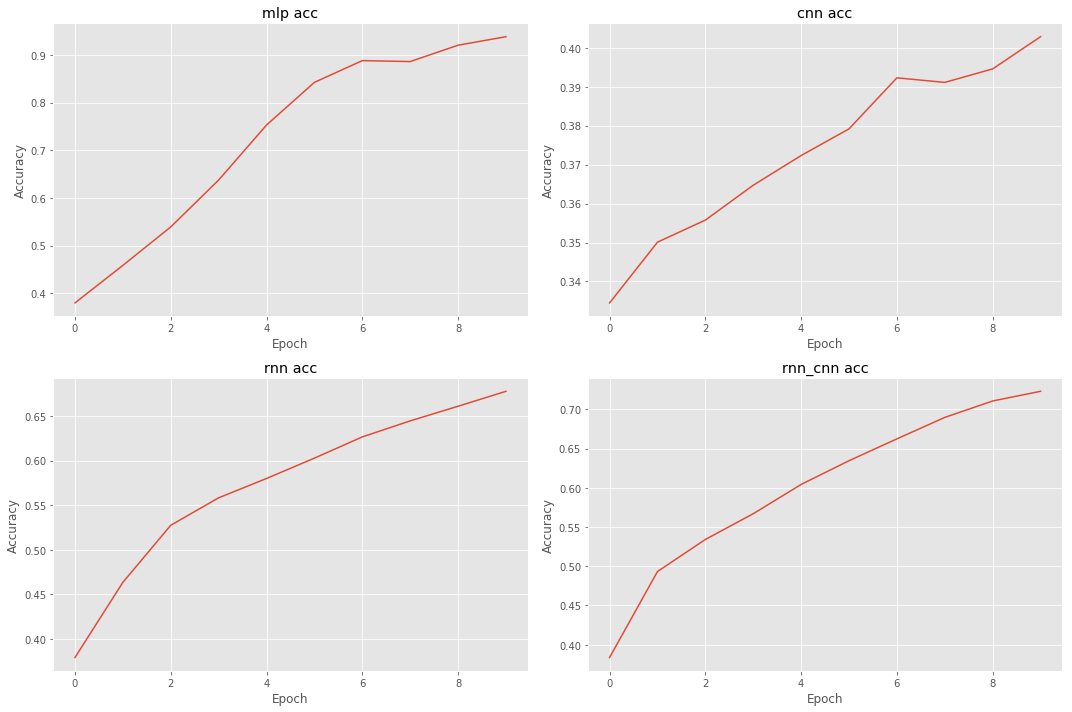

In [16]:
plot_metrics(model_dict,"acc","Epoch","Accuracy") ## Accuracy

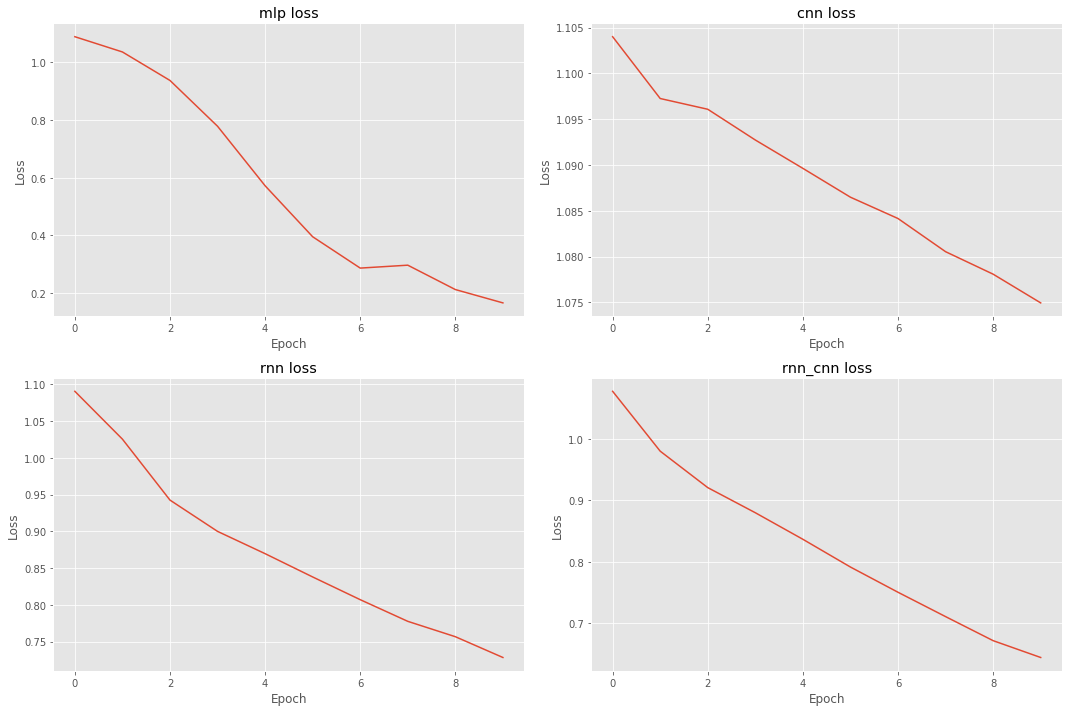

In [17]:
plot_metrics(model_dict,"loss","Epoch","Loss") ## Loss

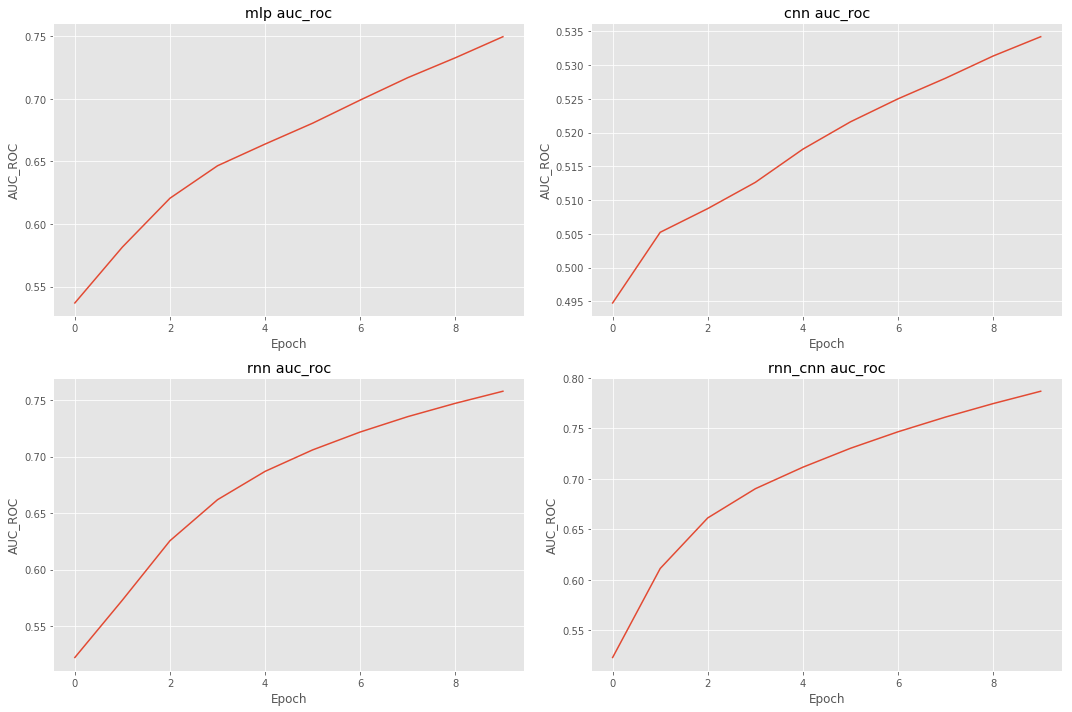

In [19]:
plot_metrics(model_dict,'auc_roc',"Epoch","AUC_ROC") ## AUC_ROC

## 4. Evaluation on Test Data
The three metrics are listed as<br>
[val_loss, val_accuracy, val_auc_roc]

In [15]:
mlp.evaluate([docs_test,X_test],y_test,batch_size=64)

5013/5013 [==============================] - 8s 2ms/step


[1.0787248851628497, 0.461998803117854, 0.5570867640658717]

In [3]:

cnn.evaluate([docs_test,X_test],y_test,batch_size=64)

5013/5013 [==============================] - 23s 5ms/step


[1.0734006599492474, 0.40394973070612455, 0.5751698227811426]

In [2]:
rnn = load_model("Data/models/rnn.hdf5",custom_objects={"auc_roc":auc_roc})
rnn.evaluate([docs_test,X_test],y_test,batch_size=64)

5013/5013 [==============================] - 401s 80ms/step


[0.9135869847142052, 0.6295631359419185, 0.797258944419147]

In [3]:
rnn_cnn = load_model("Data/models/rnn_cnn.hdf5",custom_objects={"auc_roc":auc_roc})
rnn_cnn.evaluate([docs_test,X_test],y_test,batch_size=64)

5013/5013 [==============================] - 194s 39ms/step


[0.9341351865366645, 0.6150009975137526, 0.7825800467697941]

After 10 epochs, the RNN and RNN_CNN models generalize the best. We can try extending training for more epochs to see how training improves. I focus on the CNN-RNN model as it has had comparable accuracy to the RNN model and was trained in half the time.

## 5. Extend Training for More Epochs

In [5]:
history = rnn_cnn.fit(x = [docs_train,X_train],
                      y = y_train,
                      batch_size = 32,
                      epochs = 20,
                      verbose = 1,
                      validation_data = ([docs_test,X_test],y_test))

Train on 20457 samples, validate on 5013 samples
Epoch 1/20
20457/20457 [==============================] - 3591s 176ms/step - loss: 0.6170 - acc: 0.7403 - auc_roc: 0.8936 - val_loss: 0.9954 - val_acc: 0.5783 - val_auc_roc: 0.8809
Epoch 2/20
20457/20457 [==============================] - 3583s 175ms/step - loss: 0.5874 - acc: 0.7540 - auc_roc: 0.8790 - val_loss: 1.0010 - val_acc: 0.6090 - val_auc_roc: 0.8800
Epoch 3/20
20457/20457 [==============================] - 3602s 176ms/step - loss: 0.5611 - acc: 0.7678 - auc_roc: 0.8814 - val_loss: 1.0650 - val_acc: 0.5466 - val_auc_roc: 0.8819
Epoch 4/20
20457/20457 [==============================] - 3675s 180ms/step - loss: 0.5452 - acc: 0.7749 - auc_roc: 0.8823 - val_loss: 0.9959 - val_acc: 0.6112 - val_auc_roc: 0.8838
Epoch 5/20
20457/20457 [==============================] - 3677s 180ms/step - loss: 0.5164 - acc: 0.7895 - auc_roc: 0.8856 - val_loss: 1.0316 - val_acc: 0.6346 - val_auc_roc: 0.8873
Epoch 6/20
20457/20457 [======================

In [6]:
rnn_cnn.save("Data/models/rnn_cnn1.hdf5")
with open('Data/trainHistory/rnn_cnn1.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Validation accuracy doesn't seem to be improving much, we can try training for another few epochs to be safe...

In [7]:
history2 = rnn_cnn.fit(x = [docs_train,X_train],
                      y = y_train,
                      batch_size = 32,
                      epochs = 5,
                      verbose = 1,
                      validation_data = ([docs_test,X_test],y_test))

Train on 20457 samples, validate on 5013 samples
Epoch 1/5
20457/20457 [==============================] - 3605s 176ms/step - loss: 0.3564 - acc: 0.8617 - auc_roc: 0.9115 - val_loss: 1.1948 - val_acc: 0.6010 - val_auc_roc: 0.9120
Epoch 2/5
20457/20457 [==============================] - 3605s 176ms/step - loss: 0.3480 - acc: 0.8661 - auc_roc: 0.9125 - val_loss: 1.2644 - val_acc: 0.5891 - val_auc_roc: 0.9130
Epoch 3/5
20457/20457 [==============================] - 3603s 176ms/step - loss: 0.3496 - acc: 0.8641 - auc_roc: 0.9134 - val_loss: 1.2522 - val_acc: 0.6369 - val_auc_roc: 0.9139
Epoch 4/5
20457/20457 [==============================] - 3589s 175ms/step - loss: 0.3410 - acc: 0.8680 - auc_roc: 0.9144 - val_loss: 1.4392 - val_acc: 0.6351 - val_auc_roc: 0.9147
Epoch 5/5
20457/20457 [==============================] - 3592s 176ms/step - loss: 0.3411 - acc: 0.8712 - auc_roc: 0.9150 - val_loss: 1.2874 - val_acc: 0.6022 - val_auc_roc: 0.9154


It doesn't look more epochs will improve the model any further